In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import time
from datetime import  datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()  

首先处理数据，数据需要包括 date、code、expire、type、strike、settle、position、position_itd

In [2]:
option_data = pd.read_excel('/Users/nanyueming/Desktop/毕业论文/实证/数据/回测数据_有开盘价.xlsx' , parse_dates=True)

In [3]:
option = option_data.loc[:,['date','code','expire','type','strike','open','settle','BS_IV','ivix','garch_volatility','a50_open','a50_close','vix/gv','bs/gv']]

In [4]:
option['a50_show'] = option['a50_close'] / option['a50_close'][0]

In [5]:
option.set_index('date' , drop = False , inplace = True)

接下来，定义一个函数用来找出开仓的期权组合

    首先获得每天可以作为开仓期权的组合

In [6]:
def largest_option(x):
    
    #找最远月合约
    
    ts = list(set(x))
    ts.sort()
    return ts[-1]

In [7]:
def atm_option(x):
    
    #找平值期权
    
    pg = list(set(x))
    pg.sort()
    return pg[0]

In [8]:
def straddle_options(data):
    
    #先将期权分为C、P两组
    calls = data[data['type'] == 'C']
    puts = data[data['type'] == 'P']
    #重命名行权价
    calls.rename(columns={'settle': 'call_close' , 'open': 'call_open', 'code':'call_code'}, inplace=True)
    puts.rename(columns={'settle': 'put_close' , 'open': 'put_open', 'code':'put_code'}, inplace=True)
    #合并两个表格
    option = pd.merge(calls, puts.loc[:, ['date', 'expire', 'strike', 'put_close', 'put_open' , 'put_code']], 
                      on=['date', 'expire', 'strike'], 
                      how='left').drop_duplicates()
    
    #计算剩余到期日
    option['maturity'] = (option['expire'] - option['date']).apply(lambda x: x.days)
    
    #计算平值程度
    option['strike_gap'] = abs(option['strike'] - option['a50_open'])
    
    #将两个指标筛选出来
    largest_maturities = option.groupby('date')['maturity'].apply(largest_option)
    atm_options = option.groupby('date')['strike_gap'].apply(atm_option)
    #合并
    slice_targ = pd.concat([largest_maturities , atm_options] , axis = 1 , keys = ['largest_maturity' , 'atm_option'])
    options = pd.merge(option , slice_targ , on = 'date' , how = 'left')
    #根据指标筛选期权
    back_test_options = options[(options['maturity'] == options['largest_maturity'])&(options['strike_gap'] == options['atm_option'])]
    
    return back_test_options

In [9]:
straddle_options = straddle_options(option_data)

In [10]:
straddle_options.set_index('date', drop = False , inplace = True)

意外 发现这个表格里面有重复数据，计划删除日期相同的行，只保留一行。因为不知道什么原因，导致同一天出现了到期日和距离行权价相同的期权，但是没有删掉。

In [11]:
position = straddle_options.drop_duplicates('date', keep='first')

In [12]:
position.set_index('date' , drop = False , inplace = True)
position.sort_index(inplace = True)

测试开仓指标

1）布林线

以vix/gv为指标生成开仓平仓信号

In [13]:
position['20MA_vix/gv'] = position['vix/gv'].rolling(44).mean()
position['sigma20_vix/gv'] = position['vix/gv'].rolling(44).std()
position['bolling_up_vix/gv'] = position['20MA_vix/gv'] + 1.85*position['sigma20_vix/gv']
position['bolling_low_vix/gv'] = position['20MA_vix/gv'] - 0.8*position['sigma20_vix/gv']

<AxesSubplot:xlabel='date'>

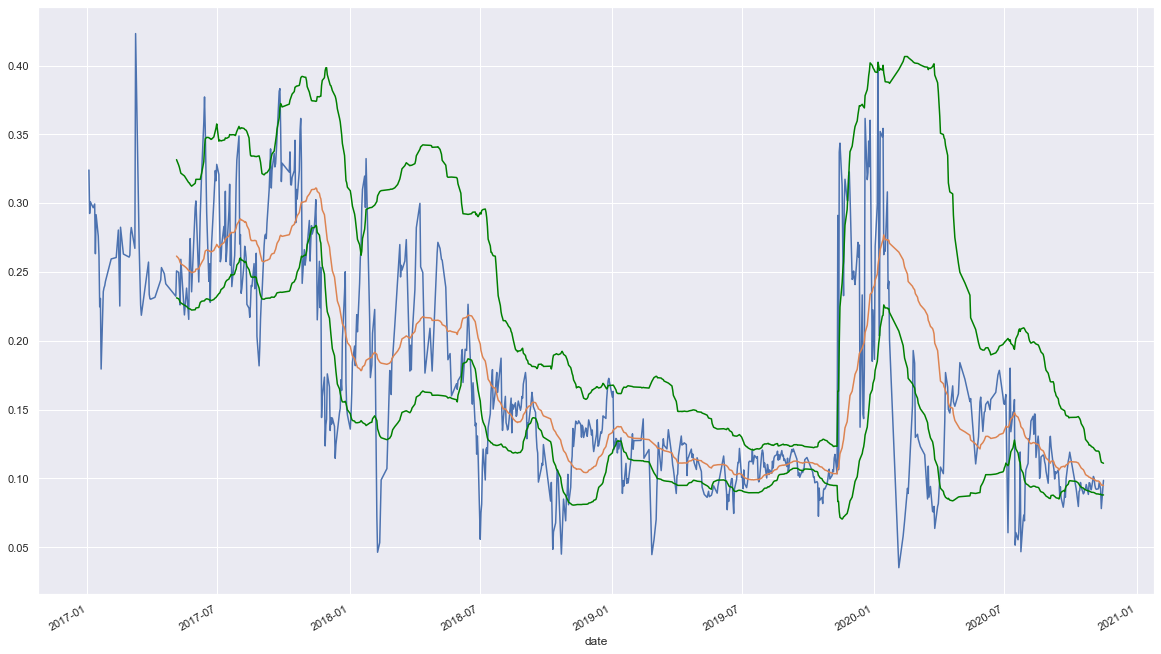

In [14]:
position['vix/gv'].plot(figsize = (20 , 12))
position['20MA_vix/gv'].plot()
position['bolling_up_vix/gv'].plot(color = 'green')
position['bolling_low_vix/gv'].plot(color = 'green')

In [15]:
position['sign_boll_vix/gv'] = 0
for i in range(len(position)):
    if position['vix/gv'][i] < position['bolling_low_vix/gv'][i]:
        position['sign_boll_vix/gv'][i] = 1
    elif position['vix/gv'][i] > position['bolling_up_vix/gv'][i]:
        position['sign_boll_vix/gv'][i] = -1
    else :position['sign_boll_vix/gv'][i] = 0

In [16]:
position['position_vix/gv'] = 0
for i in range(len(position)):
    position['position_vix/gv'][i] = position['sign_boll_vix/gv'][i] + position['position_vix/gv'][i-1]
    if position['position_vix/gv'][i] > 0 :
        position['position_vix/gv'][i] = 0
    elif position['position_vix/gv'][i] < -1 :
        position['position_vix/gv'][i] = -1
    else : position['position_vix/gv'][i] = position['position_vix/gv'][i]

In [17]:
position['position_vix/gv'].fillna(0,inplace=True)

从上面这个表格中可以通过date获取当天跨式期权组合的信息

In [18]:
vix_position = position.loc[:,['date','position_vix/gv']]

In [19]:
vix_position.rename(columns = {'position_vix/gv':'position'} , inplace = True)

In [20]:
vix_position['build_position_day'] = 0
for i in range(1 , len(vix_position)):
    if vix_position['position'][i] != 0 and vix_position['position'][i-1] == 0:
        vix_position['build_position_day'][i] = 1
    else :vix_position['build_position_day'][i] = 0    

In [21]:
vix_position['hold_position_day'] = 0
for i in range(1 , len(vix_position)):
    if vix_position['build_position_day'][i] == 0 and vix_position['position'][i] != 0:
        vix_position['hold_position_day'][i] = 1
    else :vix_position['hold_position_day'][i] = 0  

接下来，开始创建交易记录

In [22]:
vix_position['c_code'] = 0
vix_position['c_price'] = 0.0
vix_position['p_code'] = 0
vix_position['p_price'] = 0.0

In [23]:
for i in range(len(vix_position)):
    
    if (vix_position['build_position_day'][i] == 1) & (vix_position['hold_position_day'][i] == 0) :
        
        #开仓价格为第二天的开盘价
        
        date = vix_position['date'][i+1]
        
        vix_position['c_code'][i] = position[position['date']==date]['call_code']
        vix_position['c_price'][i] = position[position['date']==date]['call_open']
        vix_position['p_code'][i] = position[position['date']==date]['put_code']
        vix_position['p_price'][i] = position[position['date']==date]['put_open'] 
    
    elif (vix_position['build_position_day'][i] == 0) & (vix_position['hold_position_day'][i] == 1):
        
        #持仓日的价格只考虑当天收盘价
        
        vix_position['c_code'][i] = vix_position['c_code'][i-1]
    
        vix_position['c_price'][i] = option_data[(option_data['date']==vix_position['date'][i])&(option_data['code']==vix_position['c_code'][i])]['settle']
        
        vix_position['p_code'][i] = vix_position['p_code'][i-1]
        
        vix_position['p_price'][i] = option_data[(option_data['date']==vix_position['date'][i])&(option_data['code']==vix_position['p_code'][i])]['settle']
    
    else: 
        vix_position['c_code'][i] = vix_position['c_code'][i]
        vix_position['c_price'][i] = vix_position['c_price'][i]
        vix_position['p_code'][i] = vix_position['p_code'][i]
        vix_position['p_price'][i] = vix_position['p_price'][i]
    
    #所以在开仓信号产生的当天，录入第二天开盘价，第二天记录当天的收盘价。以此可计算持仓的收益率

计算跨式期权组合的价格

In [24]:
vix_position['stragety_price'] = vix_position['c_price'] + vix_position['p_price']

计算组合的收益率

In [25]:
vix_position['stragety_return'] = vix_position['stragety_price'].pct_change(1)

In [26]:
vix_position['stragety_return'].fillna(0,inplace = True)

In [27]:
def calculate_return(data):
    
    data['stragety_return'] = data['stragety_price'].pct_change(1)
    data['stragety_return'].fillna(0,inplace = True)
    for i in range(len(data)):
        if data['stragety_return'][i] == np.inf :
            data['stragety_return'][i] = 0
        elif data['stragety_return'][i] == -1:
            data['stragety_return'][i] = 0
        else: 
            data['stragety_return'][i] = data['stragety_return'][i]
    return data

In [28]:
def calculate_net_value(data):    
    data['net_value'] = 1.0
    for i in range(1 , len(data)):
        data['net_value'][i] = data['net_value'][i-1] * ( 1 + (data['position'][i] * data['stragety_return'][i]))
    return data


In [29]:
a = calculate_return(vix_position)

In [30]:
b = calculate_net_value(a)

<AxesSubplot:xlabel='date'>

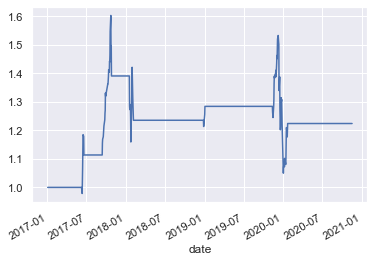

In [31]:
b['net_value'].plot()

尝试更换指标

以bs/gv为基准指标

In [32]:
position['20MA_bs/gv'] = position['bs/gv'].rolling(44).mean()
position['sigma20_bs/gv'] = position['bs/gv'].rolling(44).std()
position['bolling_up_bs/gv'] = position['20MA_bs/gv'] + 1.85*position['sigma20_bs/gv']
position['bolling_low_bs/gv'] = position['20MA_bs/gv'] - 0.8*position['sigma20_bs/gv']

<AxesSubplot:xlabel='date'>

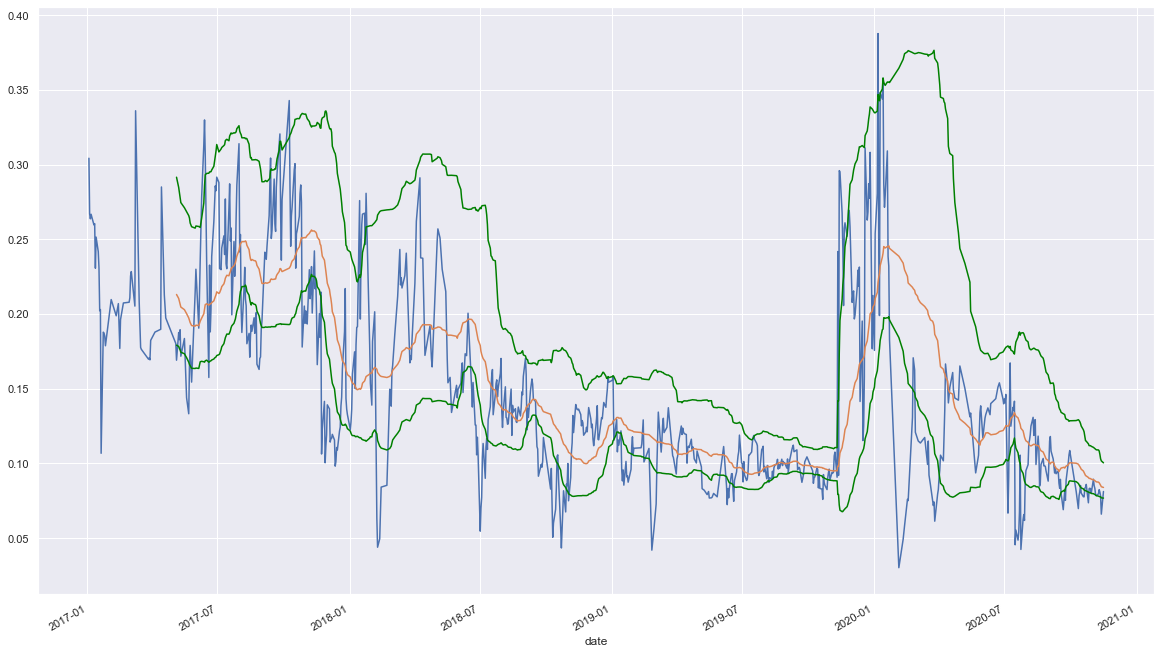

In [33]:
position['bs/gv'].plot(figsize = (20 , 12))
position['20MA_bs/gv'].plot()
position['bolling_up_bs/gv'].plot(color = 'green')
position['bolling_low_bs/gv'].plot(color = 'green')

In [34]:
position['sign_boll_bs/gv'] = 0
for i in range(len(position)):
    if position['bs/gv'][i] < position['bolling_low_bs/gv'][i]:
        position['sign_boll_bs/gv'][i] = 1
    elif position['bs/gv'][i] > position['bolling_up_bs/gv'][i]:
        position['sign_boll_bs/gv'][i] = -1
    else :position['sign_boll_bs/gv'][i] = 0

In [35]:
position['position_bs/gv'] = 0
for i in range(len(position)):
    position['position_bs/gv'][i] = position['sign_boll_bs/gv'][i] + position['position_bs/gv'][i-1]
    if position['position_bs/gv'][i] > 0 :
        position['position_bs/gv'][i] = 0
    elif position['position_bs/gv'][i] < -1 :
        position['position_bs/gv'][i] = -1
    else : position['position_bs/gv'][i] = position['position_bs/gv'][i]

In [36]:
position['position_bs/gv'].fillna(0,inplace=True)

In [37]:
bg_position = position.loc[:,['date','position_bs/gv']]

In [38]:
bg_position.rename(columns = {'position_bs/gv':'position'} , inplace = True)

In [39]:
def build_position_day(data):
    
    #用来生成开仓日和持仓日标志
    
    data['build_position_day'] = 0
    for i in range(1 , len(data)):
        if data['position'][i] != 0 and data['position'][i-1] == 0:
            data['build_position_day'][i] = 1
        else :data['build_position_day'][i] = 0   
    
    data['hold_position_day'] = 0
    for i in range(1 , len(data)):
        if data['build_position_day'][i] == 0 and data['position'][i] != 0:
            data['hold_position_day'][i] = 1
        else :data['hold_position_day'][i] = 0  
    
    return data

In [40]:
build_position_day(bg_position)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [41]:
def generate_position(data):
    
    #生成交易信息
    
    data['c_code'] = 0
    data['c_price'] = 0.0
    data['p_code'] = 0
    data['p_price'] = 0.0
    
    for i in range(len(data)):
        
        if (data['build_position_day'][i] == 1) & (data['hold_position_day'][i] == 0) :
            
            #开仓价格为第二天的开盘价
            
            date = data['date'][i+1]
            
            data['c_code'][i] = position[position['date']==date]['call_code']
            data['c_price'][i] = position[position['date']==date]['call_open']
            data['p_code'][i] = position[position['date']==date]['put_code']
            data['p_price'][i] = position[position['date']==date]['put_open'] 
    
        elif (data['build_position_day'][i] == 0) & (data['hold_position_day'][i] == 1):
            
            #持仓日的价格只考虑当天收盘价
            
            data['c_code'][i] = data['c_code'][i-1]
    
            data['c_price'][i] = option_data[(option_data['date']==data['date'][i])&(option_data['code']==data['c_code'][i])]['settle']
        
            data['p_code'][i] = data['p_code'][i-1]
        
            data['p_price'][i] = option_data[(option_data['date']==data['date'][i])&(option_data['code']==data['p_code'][i])]['settle']
        else: 
            data['c_code'][i] = data['c_code'][i]
            data['c_price'][i] = data['c_price'][i]
            data['p_code'][i] = data['p_code'][i]
            data['p_price'][i] = data['p_price'][i]
    
    #所以在开仓信号产生的当天，录入第二天开盘价，第二天记录当天的收盘价。以此可实现对持仓的收益率的计算
    
    return data

In [42]:
generate_position(bg_position)

,date,position,build_position_day,hold_position_day,c_code,c_price,p_code,p_price
date,,,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0,0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0,0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0,0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0,0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0,0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0,0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0,0,0.0


In [43]:
def net_value(data):
    
    #回测结果
    
    data['stragety_price'] = data['c_price'] + data['p_price']
    data['stragety_return'] = data['stragety_price'].pct_change(1)
    data['stragety_return'].fillna(0,inplace = True)
    net_return = calculate_return(data)
    net_value = calculate_net_value(net_return)
    net_value['net_value'].plot(figsize = (20,12))
    option['a50_show'].plot()

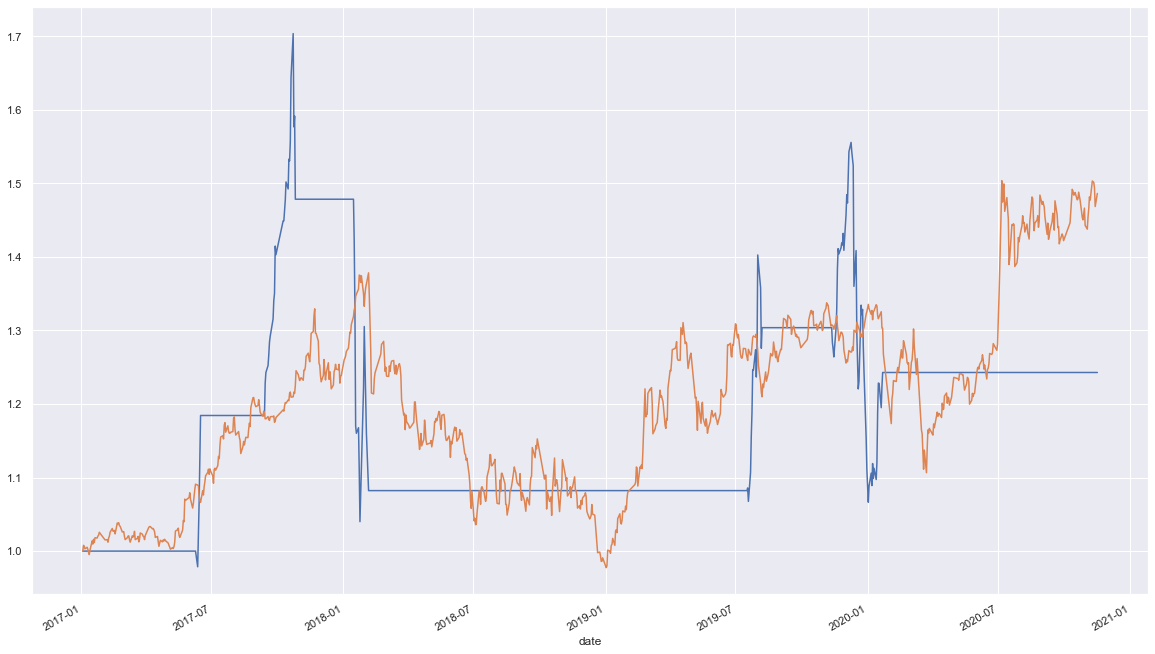

In [44]:
net_value(bg_position)

In [96]:
import math

生成评价收益的指标

In [107]:
def generate_assessment(data):
    
    #收益率
    
    return_rate = (data['net_value'][-1] - data['net_value'][0]) / data['net_value'][0]
    print('收益率 : ', return_rate)
    
    #年化收益率
     
    annualized_return = math.pow((return_rate + 1 ),(252/len(data))) - 1
    print('年化收益率 : ', annualized_return)
    
    #波动率1
    
    data['return'] = data['net_value'].pct_change(1).fillna(0)
    volatility1 = data['return'].std()
    print('波动率1 : ', volatility1)
    
    
    #年化波动率
    
    annualized_volatility = np.sqrt(252) * volatility1
    print('年化波动率 : ', annualized_volatility)
    #夏普比率
    
    sharperatio = annualized_return / annualized_volatility
    print('夏普比率 : ' , sharperatio )
    #最大回撤
    
    index_j = np.argmax(np.maximum.accumulate(data['net_value']) - data['net_value']) #最大回撤结束位置
    index_i = np.argmax(data['net_value'][:index_j])  # 最大回撤开始位置
    max_call_back = 1 - data['net_value'][index_i] / data['net_value'][index_j]
    print('做大回撤 : ' , max_call_back) 
   
    return

In [108]:
generate_assessment(bg_position)

收益率 :  0.2428934155026652
年化收益率 :  0.07210678044660024
波动率1 :  0.01566750608030605
年化波动率 :  0.2487139485184931
夏普比率 :  0.2899185223672276
做大回撤 :  -0.6381490023935781


# 更换指标 用原始波动率作为基础指标

使用整体的百分位数，统计套利

首先使用ivix指数

In [47]:
position['20MA_ivix'] = position['ivix'].rolling(30).mean()
position['sigma20_ivix'] = position['ivix'].rolling(30).std()
position['bolling_up_ivix'] = position['20MA_ivix'] + 2*position['sigma20_ivix']
position['bolling_low_ivix'] = position['20MA_ivix'] - 0.8*position['sigma20_ivix']

<AxesSubplot:xlabel='date'>

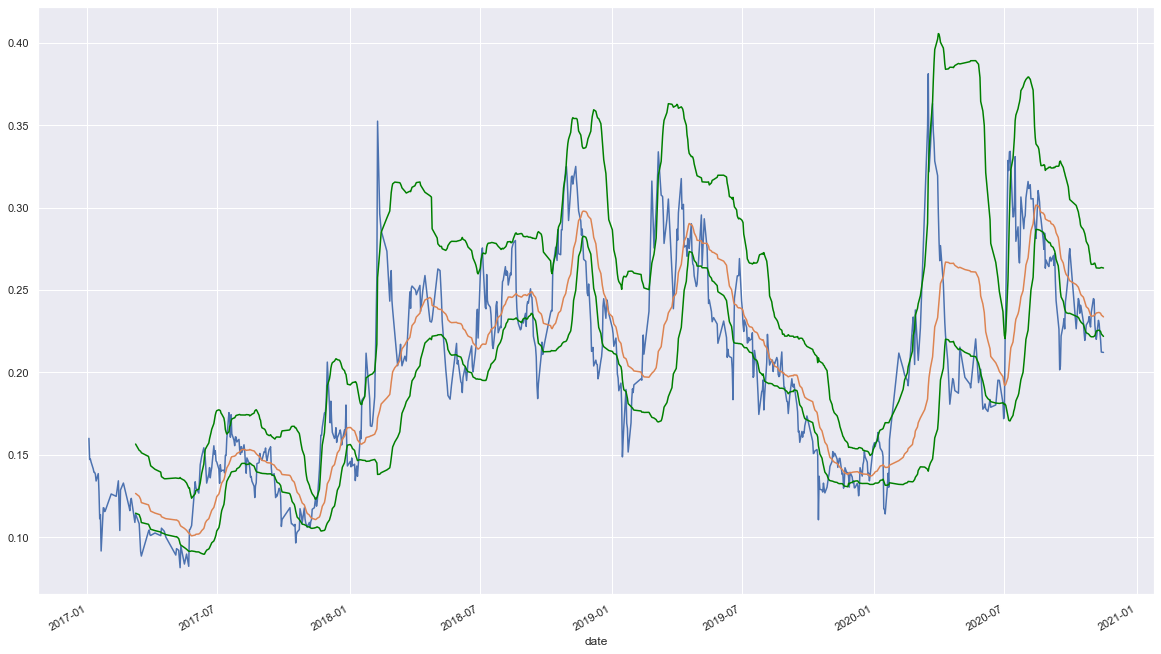

In [48]:
position['ivix'].plot(figsize = (20 , 12))
position['20MA_ivix'].plot()
position['bolling_up_ivix'].plot(color = 'green')
position['bolling_low_ivix'].plot(color = 'green')

In [49]:
position['mean_ivix'] = position['ivix'].mean() + 0.01

In [50]:
position['95_ivix'] = position['ivix'].quantile(0.97)

<AxesSubplot:xlabel='date'>

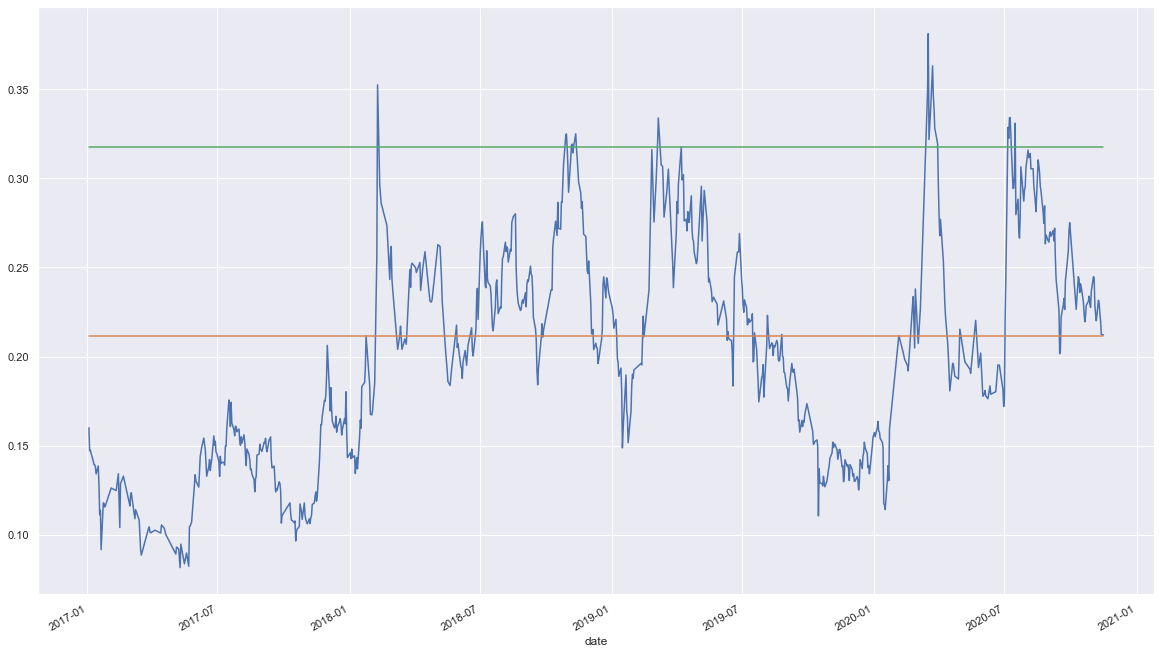

In [51]:
position['ivix'].plot(figsize = (20 , 12))
position['mean_ivix'].plot()
position['95_ivix'].plot()

In [52]:
position['sign_mean_ivix'] = 0
for i in range(len(position)):
    if position['ivix'][i] < position['mean_ivix'][i]:
        position['sign_mean_ivix'][i] = 1
    elif position['ivix'][i] > position['95_ivix'][i]:
        position['sign_mean_ivix'][i] = -1
    else :position['sign_mean_ivix'][i] = 0

In [53]:
position['position_ivix'] = 0
for i in range(len(position)):
    position['position_ivix'][i] = position['sign_mean_ivix'][i] + position['position_ivix'][i-1]
    if position['position_ivix'][i] > 0 :
        position['position_ivix'][i] = 0
    elif position['position_ivix'][i] < -1 :
        position['position_ivix'][i] = -1
    else : position['position_ivix'][i] = position['position_ivix'][i]

In [54]:
position['position_ivix'].fillna(0,inplace=True)

In [55]:
ivix_position = position.loc[:,['date','position_ivix']]

In [56]:
ivix_position.rename(columns = {'position_ivix':'position'} , inplace = True)

In [57]:
build_position_day(ivix_position)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [58]:
generate_position(ivix_position)

,date,position,build_position_day,hold_position_day,c_code,c_price,p_code,p_price
date,,,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0,0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0,0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0,0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0,0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0,0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0,0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0,0,0.0


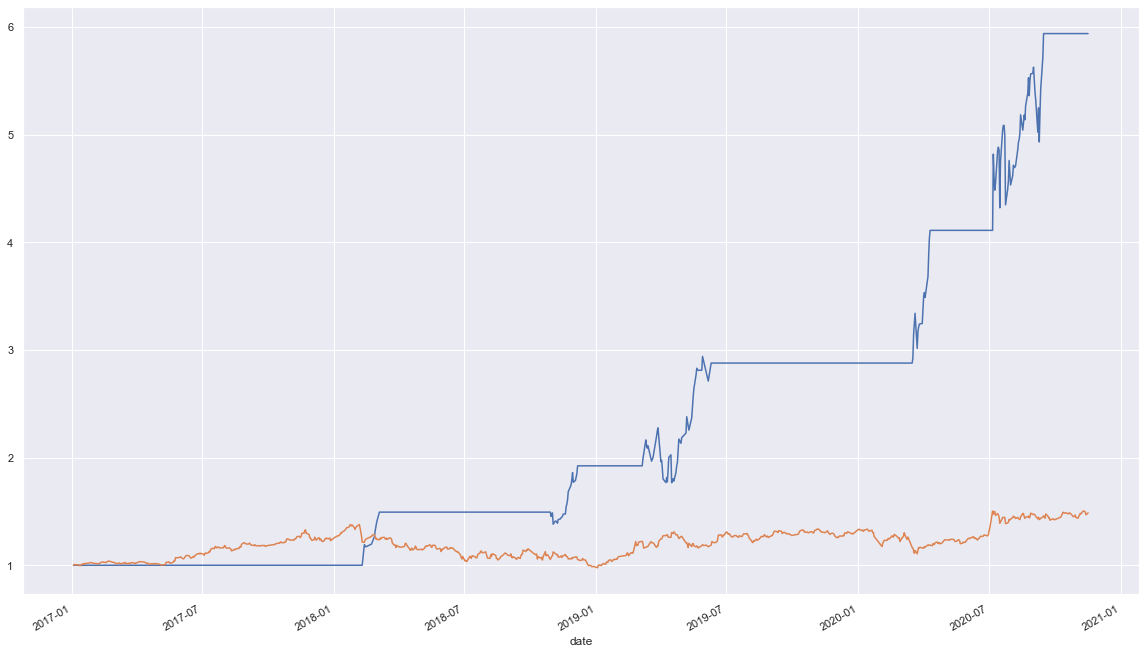

In [59]:
net_value(ivix_position)

In [109]:
generate_assessment(ivix_position)

收益率 :  4.937458203790042
年化收益率 :  0.7689251506501509
波动率1 :  0.020311025262656778
年化波动率 :  0.32242753030644117
夏普比率 :  2.3847999267288063
做大回撤 :  -0.1699598293482416


使用garch波动率

In [61]:
position['mean_garch'] = position['garch_volatility'].mean()+0.5

In [62]:
position['95_garch'] = position['garch_volatility'].quantile(0.97)

<AxesSubplot:xlabel='date'>

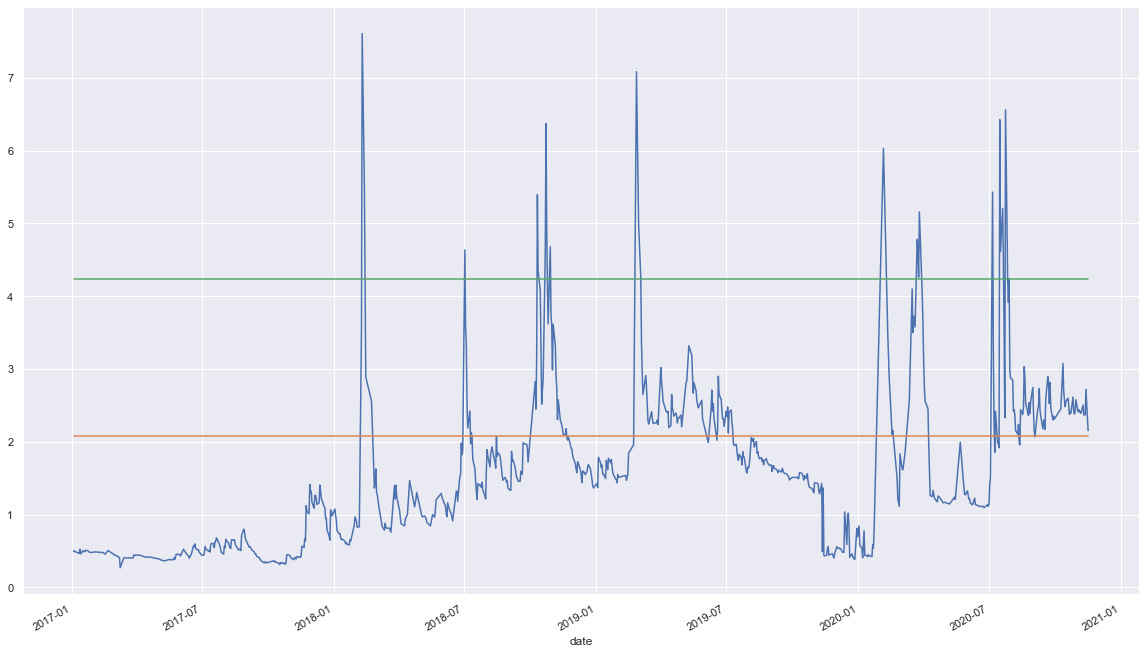

In [63]:
position['garch_volatility'].plot(figsize = (20 , 12))
position['mean_garch'].plot()
position['95_garch'].plot()

In [64]:
position['sign_mean_garch'] = 0
for i in range(len(position)):
    if position['garch_volatility'][i] < position['mean_garch'][i]:
        position['sign_mean_garch'][i] = 1
    elif position['garch_volatility'][i] > position['95_garch'][i]:
        position['sign_mean_garch'][i] = -1
    else :position['sign_mean_garch'][i] = 0

In [65]:
position['position_garch'] = 0
for i in range(len(position)):
    position['position_garch'][i] = position['sign_mean_garch'][i] + position['position_garch'][i-1]
    if position['position_garch'][i] > 0 :
        position['position_garch'][i] = 0
    elif position['position_garch'][i] < -1 :
        position['position_garch'][i] = -1
    else : position['position_garch'][i] = position['position_garch'][i]

In [66]:
position['position_garch'].fillna(0,inplace=True)

In [67]:
garch_position = position.loc[:,['date','position_garch']]

In [68]:
garch_position.rename(columns = {'position_garch':'position'} , inplace = True)

In [69]:
build_position_day(garch_position)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,0,0,0
2020-11-11,2020-11-11,0,0,0
2020-11-12,2020-11-12,0,0,0


In [70]:
generate_position(garch_position)

,date,position,build_position_day,hold_position_day,c_code,c_price,p_code,p_price
date,,,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0,0,0.0
2017-01-04,2017-01-04,0,0,0,0,0.0,0,0.0
2017-01-05,2017-01-05,0,0,0,0,0.0,0,0.0
2017-01-06,2017-01-06,0,0,0,0,0.0,0,0.0
2017-01-09,2017-01-09,0,0,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
2020-11-10,2020-11-10,0,0,0,0,0.0,0,0.0
2020-11-11,2020-11-11,0,0,0,0,0.0,0,0.0
2020-11-12,2020-11-12,0,0,0,0,0.0,0,0.0


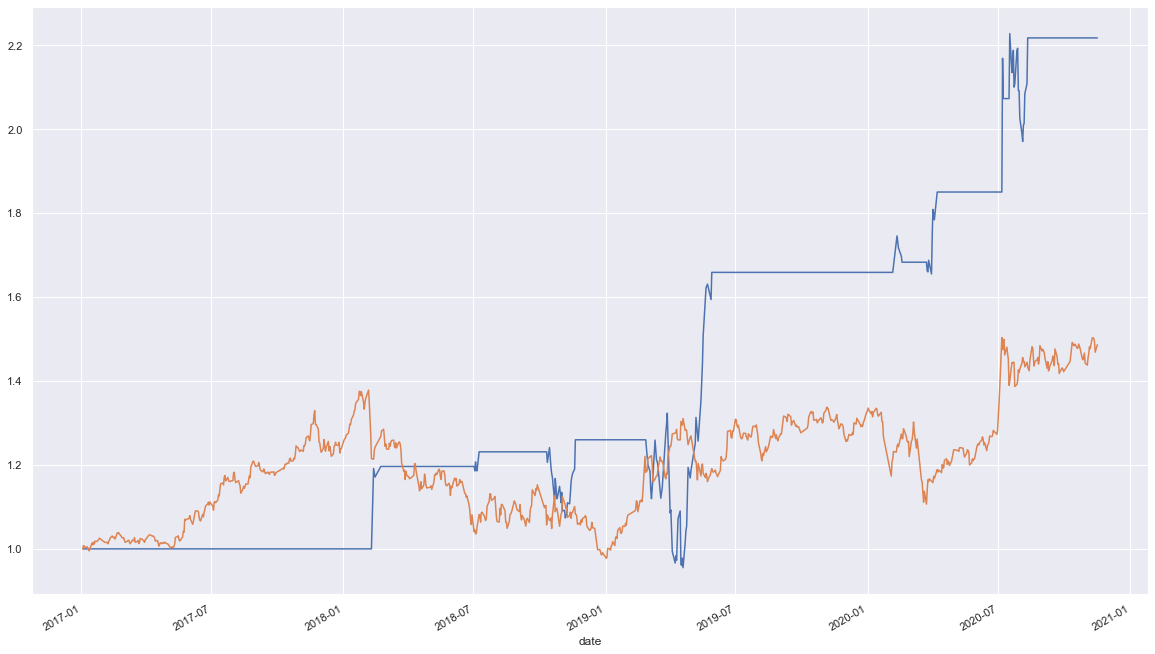

In [71]:
net_value(garch_position)

In [110]:
generate_assessment(garch_position)

收益率 :  1.217575992594127
年化收益率 :  0.2904804867305115
波动率1 :  0.017687251696079168
年化波动率 :  0.2807764161841852
夏普比率 :  1.0345615585461445
做大回撤 :  -0.3854332894590087


用加权BS波动率

In [73]:
position['mean_bs'] = position['BS_IV'].mean()

In [74]:
position['95_bs'] = position['BS_IV'].quantile(0.97)

<AxesSubplot:xlabel='date'>

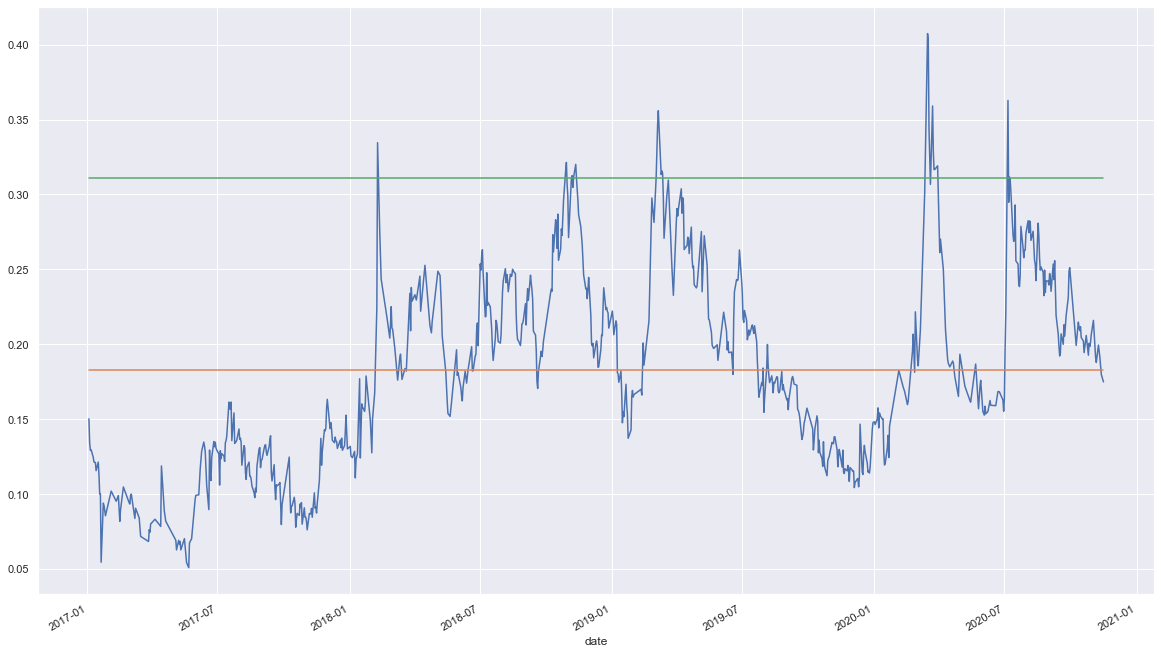

In [75]:
position['BS_IV'].plot(figsize = (20 , 12))
position['mean_bs'].plot()
position['95_bs'].plot()

In [76]:
position['sign_mean_bs'] = 0
for i in range(len(position)):
    if position['BS_IV'][i] < position['mean_bs'][i]:
        position['sign_mean_bs'][i] = 1
    elif position['BS_IV'][i] > position['95_bs'][i]:
        position['sign_mean_bs'][i] = -1
    else :position['sign_mean_bs'][i] = 0

In [77]:
position['position_bs'] = 0
for i in range(len(position)):
    position['position_bs'][i] = position['sign_mean_bs'][i] + position['position_bs'][i-1]
    if position['position_bs'][i] > 0 :
        position['position_bs'][i] = 0
    elif position['position_bs'][i] < -1 :
        position['position_bs'][i] = -1
    else : position['position_bs'][i] = position['position_bs'][i]

In [78]:
position['position_bs'].fillna(0,inplace=True)

In [79]:
bs_position = position.loc[:,['date','position_bs']]

In [80]:
bs_position.rename(columns = {'position_bs':'position'} , inplace = True)

In [81]:
build_position_day(bs_position)

,date,position,build_position_day,hold_position_day
date,,,,
2017-01-03,2017-01-03,0,0,0
2017-01-04,2017-01-04,0,0,0
2017-01-05,2017-01-05,0,0,0
2017-01-06,2017-01-06,0,0,0
2017-01-09,2017-01-09,0,0,0
...,...,...,...,...
2020-11-10,2020-11-10,-1,0,1
2020-11-11,2020-11-11,-1,0,1
2020-11-12,2020-11-12,-1,0,1


In [82]:
generate_position(bs_position)

,date,position,build_position_day,hold_position_day,c_code,c_price,p_code,p_price
date,,,,,,,,
2017-01-03,2017-01-03,0,0,0,0,0.0000,0,0.0000
2017-01-04,2017-01-04,0,0,0,0,0.0000,0,0.0000
2017-01-05,2017-01-05,0,0,0,0,0.0000,0,0.0000
2017-01-06,2017-01-06,0,0,0,0,0.0000,0,0.0000
2017-01-09,2017-01-09,0,0,0,0,0.0000,0,0.0000
...,...,...,...,...,...,...,...,...
2020-11-10,2020-11-10,-1,0,1,10002643,0.0840,10002644,0.1233
2020-11-11,2020-11-11,-1,0,1,10002643,0.0813,10002644,0.1182
2020-11-12,2020-11-12,-1,0,1,10002643,0.0697,10002644,0.1247


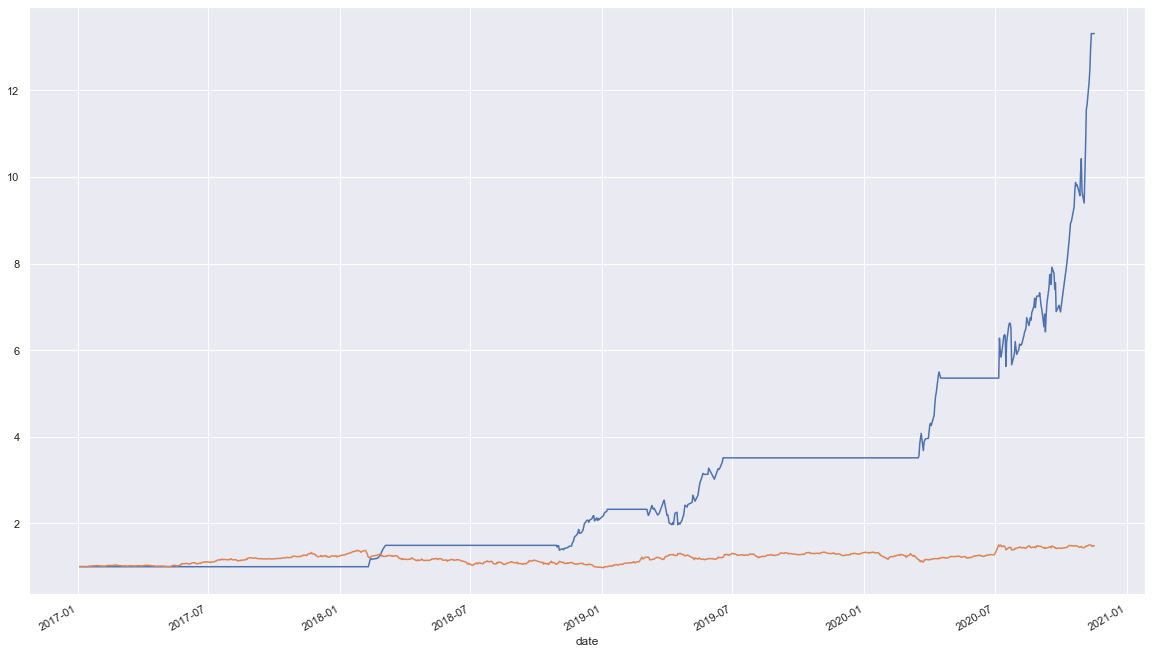

In [83]:
net_value(bs_position)

In [111]:
generate_assessment(bs_position)

收益率 :  12.312883882164618
年化收益率 :  1.2908447320665797
波动率1 :  0.02323181175231087
年化波动率 :  0.36879357841249355
夏普比率 :  3.500182236423805
做大回撤 :  -0.14999231171636507


In [85]:
a50etf = pd.read_excel('/Users/nanyueming/Desktop/毕业论文/实证/数据/上证50ETF.xlsx' , parse_dates = True)

In [86]:
a50etf.rename(columns = {'收盘价(元)':'close'}, inplace = True)

In [87]:
a50etf.set_index('时间', inplace = True)

<AxesSubplot:xlabel='时间'>

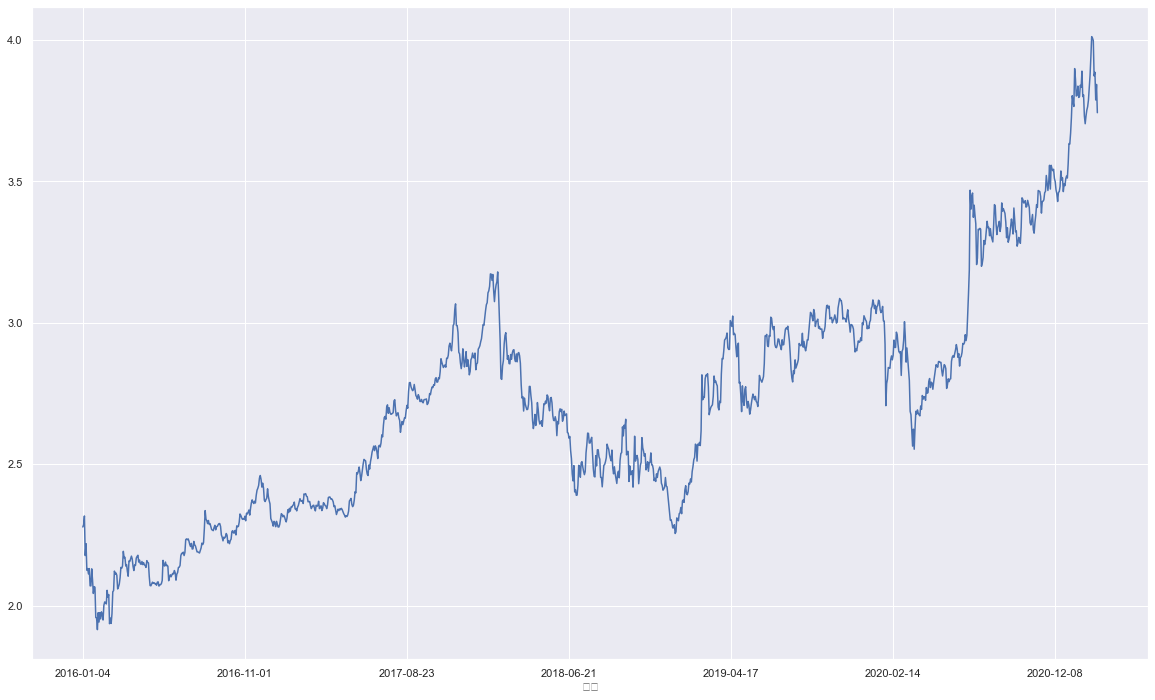

In [88]:
a50etf.close.plot(figsize = (20, 12))

In [89]:
a50etf['return'] = a50etf['close'].pct_change()

In [90]:
a50etf.fillna(0)

,代码,简称,开盘价(元),最高价(元),最低价(元),close,return
时间,,,,,,,
2016-01-04,510050.OF,50ETF,2.411,2.413,2.271,2.278,0.000000
2016-01-05,510050.OF,50ETF,2.260,2.311,2.230,2.286,0.003512
2016-01-06,510050.OF,50ETF,2.290,2.320,2.275,2.317,0.013561
2016-01-07,510050.OF,50ETF,2.286,2.286,2.165,2.177,-0.060423
2016-01-08,510050.OF,50ETF,2.236,2.259,2.156,2.219,0.019293
...,...,...,...,...,...,...,...
2021-02-22,510050.OF,50ETF,4.002,4.005,3.866,3.873,-0.031266
2021-02-23,510050.OF,50ETF,3.849,3.927,3.845,3.886,0.003357
2021-02-24,510050.OF,50ETF,3.887,3.896,3.752,3.788,-0.025219


In [91]:
a50etf['volatility'] = a50etf['return']**2

In [92]:
a50etf['vol_30'] = a50etf['volatility'].rolling(30).mean()

<AxesSubplot:xlabel='时间'>

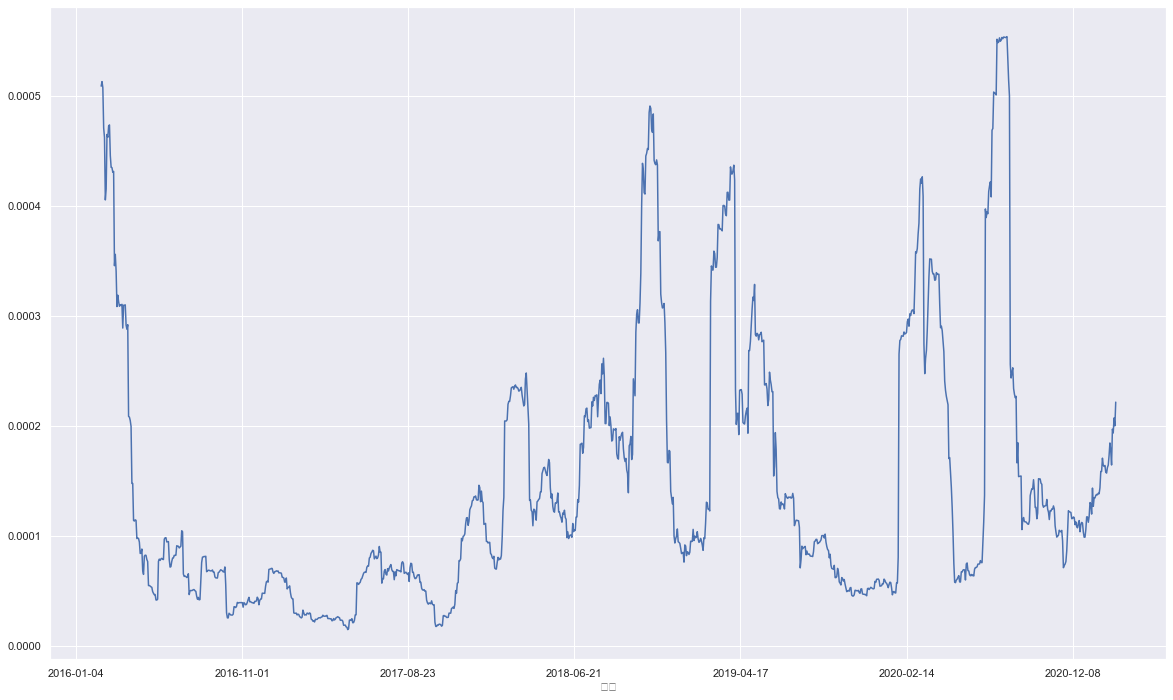

In [93]:
a50etf['vol_30'].plot(figsize = (20, 12))
